### Partie_EDA :

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import re
import seaborn as sns

In [2]:
dataset = pd.read_excel('get_around_delay_analysis .xlsx')
dataset.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


## compréhension des features :

* rental_id : Identifiant unique de la location
* car_id : Identifiant unique de la voiture
* checkin_type :
* mobile = contrat de location signé sur le smartphone du propriétaire
* connect = voiture équipée de la technologie Connect , ouverte par le conducteur avec son smartphone. Remarque : les contrats papier ont été exclus des données 
* delay_at_checkout_in_minutes : Différence en minutes entre l’heure de fin de location demandée par le conducteur lors de la réservation de la voiture et l’heure réelle à laquelle le conducteur a effectué le paiement. Les valeurs négatives signifient que le conducteur a rendu la voiture à l’avance.
* previous_ended_rental_id de la location précédente de la voiture (NULL quand aucune *location précédente ou retard avec location précédente supérieure à 12 heures)
* time_delta_with_previous_rental_in_minutes Différence en minutes entre cette heure de début de location prévue et l’heure de fin de location prévue précédente (si inférieure à 12 heures, NULL si supérieure).

In [3]:
dataset.isna().sum()

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64

In [4]:
checkout = []
for x in dataset['delay_at_checkout_in_minutes']:
    if x < 0:
        checkout.append('Early')
    elif x < 15:
        checkout.append('Late 0-15')
    elif x < 30:
        checkout.append('Late 15-30')
    elif x < 60:
        checkout.append('Late 30-60')
    elif x < 120 :
        checkout.append('Late 60-120')
    elif x >= 120 :
        checkout.append('Very late')        
    else:
        checkout.append('NA')

dataset['checkout'] = checkout
dataset['checkout'].value_counts()

checkout
Early          6820
NA             4964
Very late      2568
Late 0-15      2003
Late 60-120    1860
Late 30-60     1722
Late 15-30     1373
Name: count, dtype: int64

In [5]:
dataset['next_rental'] = [True if x > 0 else False for x in dataset.previous_ended_rental_id]

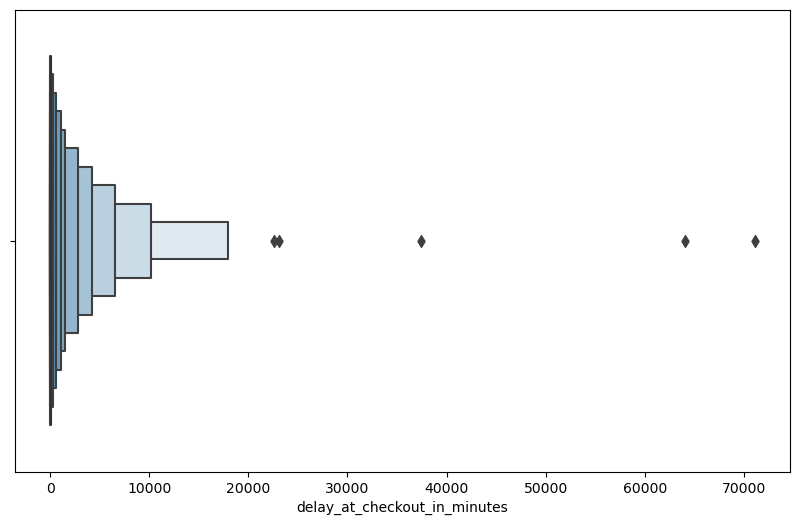

In [6]:
plt.figure(figsize=(10,6))
sns.boxenplot(data=dataset[dataset['checkout']!='Early'], x='delay_at_checkout_in_minutes',scale='linear')
plt.show()

We can see some outliers, possibly even wrong values (71084 minutes, that's nearly 50 days !)

In [7]:
delays = []
for x in dataset['delay_at_checkout_in_minutes']:
    if x < dataset['delay_at_checkout_in_minutes'].quantile(0.01):
        delays.append(np.nan)
    elif x > dataset['delay_at_checkout_in_minutes'].quantile(0.99):
        delays.append(np.nan)     
    else:
        delays.append(x)

dataset['delays_checkout_min_cleaned'] = delays

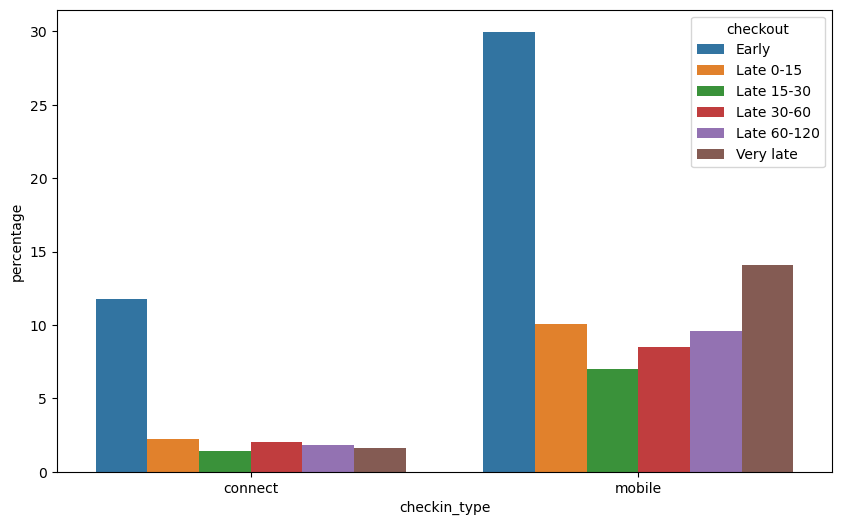

In [8]:
checkout_clean = dataset.dropna(subset=['delay_at_checkout_in_minutes'])
checktype_checkout = checkout_clean.groupby(['checkin_type','checkout']).size().reset_index(name='count')
checktype_checkout['percentage'] = [i / checktype_checkout['count'].sum() * 100 for i in checktype_checkout['count']]

plt.figure(figsize=(10,6))
sns.barplot(y=checktype_checkout['percentage'],x=checktype_checkout['checkin_type'], hue=checktype_checkout['checkout'],orient='vertical')
plt.show()


In [9]:
dataset.checkout.value_counts()/dataset.checkout.count()*100

checkout
Early          32.003754
NA             23.294228
Very late      12.050680
Late 0-15       9.399343
Late 60-120     8.728297
Late 30-60      8.080713
Late 15-30      6.442985
Name: count, dtype: float64

In [10]:
import plotly.express as px


In [11]:
fig1 = px.histogram(
    data_frame=dataset,
    x='delay_at_checkout_in_minutes',
    color='checkin_type',
    histnorm='percent',
    barmode='overlay'
)

# Show the plot
fig1.show()

In [12]:
fig2 = px.histogram(
    data_frame=dataset,
    x='time_delta_with_previous_rental_in_minutes',
    color='checkin_type',
    nbins=100,
    histnorm='percent',
    barmode='overlay'
)

# Show the plot
fig2.show()

In [13]:
cols_cat  = [ 'car_id', 'checkin_type',
             'state' ]

cols_num = ['time_delta_with_previous_rental_in_minutes',
            'delay_at_checkout_in_minutes']

### Pouvons-nous estimer les pertes financières  en raison des retards?

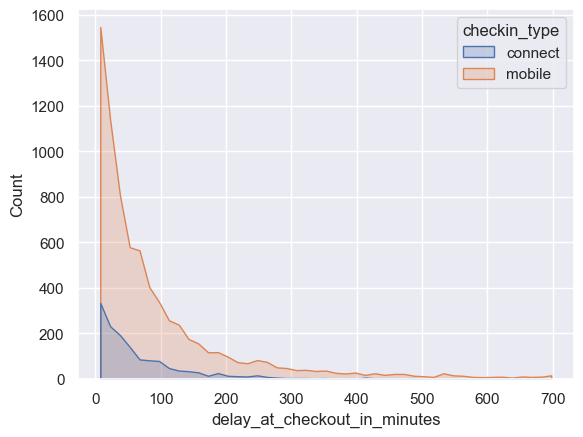

In [17]:
late_drivers = dataset["delay_at_checkout_in_minutes"] > 0
df_late_drivers = dataset[late_drivers]
sns.set(style="darkgrid")
sns.histplot(data=df_late_drivers, x="delay_at_checkout_in_minutes", hue="checkin_type", element="poly", bins=np.arange(0, 60*12, step=15)) ## (60*12) for 12 hours
plt.show()

In [18]:
df_late_drivers_mobile = df_late_drivers[df_late_drivers["checkin_type"] == "mobile"]
df_late_drivers_connect = df_late_drivers[df_late_drivers["checkin_type"] == "connect"]
delay_median_mobile = np.median(df_late_drivers_mobile["delay_at_checkout_in_minutes"])
delay_median_connect = np.median(df_late_drivers_connect["delay_at_checkout_in_minutes"])

In [21]:
df_2=pd.read_csv('get_around_pricing_project.csv')
df_2.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [22]:
nb_delays = len(df_late_drivers_mobile)
print(f"{nb_delays} are concerned by delays (short/long)")
delay_median_mobile = np.median(df_late_drivers_mobile["delay_at_checkout_in_minutes"])
print(f"the delay is about : {delay_median_mobile} minutes")
avg_price_rent_by_day = np.mean(df_2["rental_price_per_day"]) ## price by day
print(f"Plus we know that the average price of car rent is about : {avg_price_rent_by_day}$ by day")
avg_price_rent_by_min = avg_price_rent_by_day / 1_440
print(f"That represent : {round(avg_price_rent_by_min, ndigits=3)} $ by minute")
money_loss = avg_price_rent_by_min * delay_median_mobile
print(f"so getaround loss about {money_loss} $ for each delay")
print(f"so getaround loss about {money_loss * nb_delays} $ for {nb_delays} delays")

7945 are concerned by delays (short/long)
the delay is about : 56.0 minutes
Plus we know that the average price of car rent is about : 121.21453644435267$ by day
That represent : 0.084 $ by minute
so getaround loss about 4.713898639502604 $ for each delay
so getaround loss about 37451.92469084819 $ for 7945 delays
